# Iris task 

The code was originally made in VSCode, but is put into Jupyter notebook to make it easyer for you to run. The run times are higher here in jupyter and some extra code lines had to be added. The .py file is the actual code that was used and run for the report.

The confusion matrices used in the report are made by saving the data in .mat files and running them in a matlab script. We have also plotted the matrices here in jupyter to make it easyer for you.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix
import seaborn as sns

def main(alpha, Niterations, trainFirst, indexRemoveFeature,):
    #indexRemoveFeature                                         #index of features we want to remove e.g. [0,1,2]
    #alpha                                                      #step factor  e.g. [0.1,0.01,0.001,0.0001]
    #Niterations                                                #iterations of backpropagation
    #trainFirst                                                 #True if we use first 30 for training
    C = 3                                                       #number of classes
    D = 4 - len(indexRemoveFeature)                             #number of features
    Ntrain = 30                                                 #number of traning data for one class
    Ntest  = 20                                                 #number of test data for one class
    NtrainAll = Ntrain*C                                        #number of traning data for all classes
    NtestAll = Ntest*C                                          #number of test data for all classes
    ConfMatrixTrain = np.zeros([C,C])                           #initialize confusion matrix for train data 
    ConfMatrixTest = np.zeros([C,C])                            #initialize confusion matrix for test data 
    AllMSETrain = [[0]*Niterations for i in range(len(alpha))]  #array of all mean sqare errors
    AllMSETest =  [[0]*Niterations for i in range(len(alpha))]  #array of all mean sqare errors

    #-----------THE DIFFERENT CASES THAT ARE TESTED-----------#
    if (trainFirst == True):
        xTrain, xTest, tTrain, tTest = splitData('iris.data', Ntrain, indexRemoveFeature) #trained using a first 30 samples
    else:
        xTest, xTrain, tTest, tTrain = splitData('iris.data', Ntest, indexRemoveFeature) #trained using a last 30 samples
    
    #-----------THE CLASSIFIER IS TRAINED AND THE MSE IS FOUND-----------#
    for j in range(len(alpha)):
        W = np.zeros((C,D+1))   
        for i in range(Niterations): 

            zTrain, gTrain, MSETrain, GradMSETrain = findMSE(xTrain,tTrain, NtrainAll, C, W)

            W = W - alpha[j]*GradMSETrain
            
            AllMSETrain[j][i] = MSETrain

            zTest, gTest, MSETest, GradMSETest = findMSE(xTest, tTest, NtestAll, C, W)

            AllMSETest[j][i] = MSETest
    
    #Print differently when testing different alpha
    if len(alpha) > 1:
        for j in range(len(alpha)):
            plt.plot(AllMSETrain[j], label=f"Training data \u03B1={alpha[j]}") #plots the MSE for each alpha
        plt.xlabel('iterations')
        plt.ylabel('MSE')
        plt.title('MSE for differenet \u03B1')
        plt.legend()
    else: 
        # makes Conf. Matrix for Training data
        for k in range(NtrainAll):
            ConfMatrixTrain[np.argmax(tTrain[k])][np.argmax(gTrain[k])] += 1
        io.savemat('confmatrixTrain.mat', {"ConfmatrixTrain": ConfMatrixTrain }) #saves the conf. matrix as .mat file
        
        # makes ConfMatrix for Testing data
        for k in range(NtestAll):
            ConfMatrixTest[np.argmax(tTest[k])][np.argmax(gTest[k])] += 1
        io.savemat('confmatrixTest.mat', {"ConfmatrixTest": ConfMatrixTest }) #saves the conf. matrix as .mat file
        
        ########################################################### Matrix Implemented so it is easier for you to run the code
        fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (15,5))
        
        cmTrain = sns.heatmap(ConfMatrixTrain, annot=True, cmap='Blues', ax=ax1)
        cmTrain.set_title('Iris flower classification Training data\n\n');
        cmTrain.set_xlabel('\nPredicted Class')
        cmTrain.set_ylabel('True Class ');
        cmTrain.xaxis.set_ticklabels(['Setosa','Virginica','Versicolor'])
        cmTrain.yaxis.set_ticklabels(['Setosa','Virginica','Versicolor'])
        
        cmTest = sns.heatmap(ConfMatrixTest, annot=True, cmap='Blues', ax=ax2)
        cmTest.set_title('Iris flower classification Testing data\n\n');
        cmTest.set_xlabel('\nPredicted Class')
        cmTest.set_ylabel('True Class ');
        cmTest.xaxis.set_ticklabels(['Setosa','Virginica','Versicolor'])
        cmTest.yaxis.set_ticklabels(['Setosa','Virginica','Versicolor'])
        
        ########################################################################

        #printing and displaying of weighting functions
        print ('Weighting matrix:')
        for line in W:
            print ('\n ', '   '.join(map(str, line)))

        #printing of the error rates and histograms
        print(f'Error rate(train): {round(findErrorRate(ConfMatrixTrain,NtrainAll, C),5)}% \n')
        print(f'Error rate(test):  {round(findErrorRate(ConfMatrixTest,NtrainAll, C),5)}% \n')
    
    plt.show()

#-----------FETCHES AND SPLITS THE DATA-----------#
def splitData(fileName, N, col = None):
    df = pd.read_csv(fileName, header = None)
    df[4] = 1 

    if (col != None):
        for i in col:
            df.drop(i, inplace=True, axis=1)
    
    df_S    = df.iloc[   :50 ]
    df_Vc   = df.iloc[50 :100]
    df_Vg   = df.iloc[100:150]


    df_S_train  =  df_S.iloc[:N]
    df_S_test   =  df_S.iloc[N:]
    df_Vc_train = df_Vc.iloc[:N]
    df_Vc_test  = df_Vc.iloc[N:]
    df_Vg_train = df_Vg.iloc[:N]
    df_Vg_test  = df_Vg.iloc[N:]

    firstX      = np.concatenate((df_S_train,df_Vc_train,df_Vg_train), axis=0) #training data 
    secondX     = np.concatenate((df_S_test,df_Vc_test,df_Vg_test), axis=0) #testing data

    firstTS     = np.tile(np.array([[1,0,0]]), (N, 1))
    firstTVc    = np.tile(np.array([[0,1,0]]), (N, 1))
    firstTVg    = np.tile(np.array([[0,0,1]]), (N, 1))
    firstT      = np.concatenate((firstTS,firstTVc,firstTVg),axis=0)               

    secondTS    = np.tile(np.array([[1,0,0]]), (50-N, 1))
    secondTVc   = np.tile(np.array([[0,1,0]]), (50-N, 1))
    secondTVg   = np.tile(np.array([[0,0,1]]), (50-N, 1))
    secondT     = np.concatenate((secondTS,secondTVc,secondTVg),axis=0)

    return firstX, secondX, firstT, secondT

#-----------IMPLEMENTATION OF THE LDC-----------#
def findMSE(x_local, t_local, N, C, W):
    z_local = np.empty([N,C]) 
    g_local = np.empty([N,C]) 
    MSE_local = 0
    GradMSE_local = 0 
    for k in range(N):
        z_local[k]=np.dot(W,x_local[k].T)  

        g_local[k]=1/(1+np.exp(-z_local[k]))

        MSE_local += 0.5*np.dot((g_local[k]-t_local[k]).T,(g_local[k]-t_local[k]))
        GradMSE_local += np.outer(((g_local[k]-t_local[k])*g_local[k]*(1-g_local[k])), x_local[k]) 
    return z_local, g_local, MSE_local, GradMSE_local

#-----------FINDS THE ERROR RATES-----------#
def findErrorRate(ConfMatrixTrain, N, C):
    errorRate = 0
    for i in range(C):
        for j in range(C):
            if (i != j):
                errorRate += ConfMatrixTrain[i][j]/N
    return errorRate

#-----------PLOTS THE HISTOGRAMS AND FINDS THE OVERLAPP BETWEEN THE BINS-----------#
def histogram(fileName):
    df = pd.read_csv(fileName, header = None)
    sepalLength = np.array(df[0])
    sepalWidth  = np.array(df[1])
    petalLength = np.array(df[2])
    petalWidth  = np.array(df[3])

    
    classType = [sepalLength, sepalWidth, petalLength, petalWidth]
    className = ['Sepal Length[cm]', 'Sepal Width [cm]', 'Petal length[cm]', 'Petal width[cm]']

    for i in range(4):
        fig, axs = plt.subplots(3, 1, sharex=True, tight_layout=True)
        axs[0].hist(classType[i][:50], bins=16, color = "mediumseagreen")
        axs[0].set_title('Iris-setosa')
        axs[0].set_ylabel('samples per bin')
        axs[1].hist(classType[i][50:100], bins=16, color = "#77AC30")
        axs[1].set_title('Iris-versicolor')
        axs[1].set_ylabel('samples per bin')
        axs[2].hist(classType[i][100:150], bins=16, color = "mediumaquamarine")
        axs[2].set_title('Iris-virginica')
        axs[2].set_ylabel('samples per bin')
        axs[2].set_xlabel(className[i])

    #Find Overlap
    [overlapSepalLength, overlapSepalWidth, overlapPetalLength, overlapPetalWidth] = [0,0,0,0]
    overlap = [overlapSepalLength, overlapSepalWidth, overlapPetalLength, overlapPetalWidth]
    overlapPrint = ["Overlap Sepal Length: ", "Overlap Sepal Width: ", "Overlap Petal Length: ", "Overlap Petal Width: "]
    ranges = [(4,8), (2,4.5), (0.5,7),(0,2.5)]

    for i in range(4):
        counts1, _ = np.histogram(classType[i][0:50],    bins=16, range = ranges[i])
        counts2, _ = np.histogram(classType[i][50:100],  bins=16, range = ranges[i])
        counts3, _ = np.histogram(classType[i][100:150], bins=16, range = ranges[i])

        overlap[i] = np.sum(np.minimum(counts1,counts2))\
        + np.sum(np.minimum(counts1,counts3))\
        + np.sum(np.minimum(counts2,counts3))
        print(overlapPrint[i], overlap[i])

# Plots the histograms and the overlapp

Overlap Sepal Length:  42
Overlap Sepal Width:  78
Overlap Petal Length:  8
Overlap Petal Width:  6


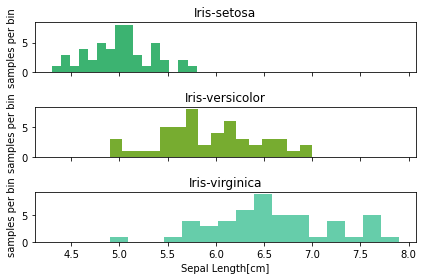

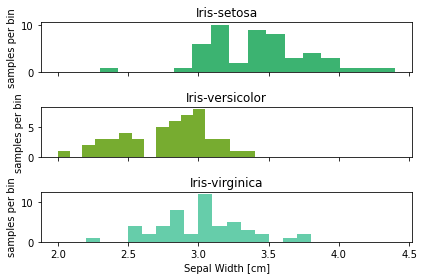

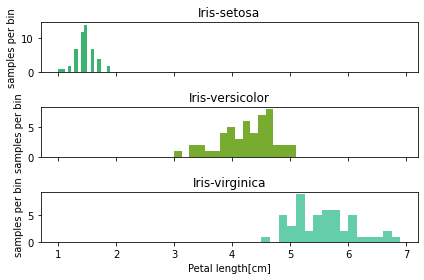

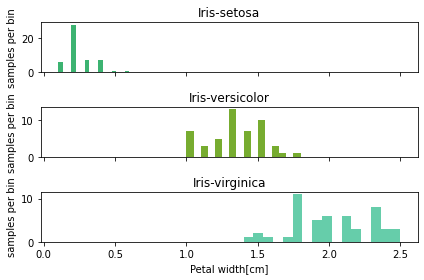

Run time: 2.3808109999999942


In [10]:
from timeit import default_timer as timer

start = timer()
histogram('iris.data')
plt.show()
end = timer()

print(f'Run time: {end - start}')

# Test for different alpha and plots

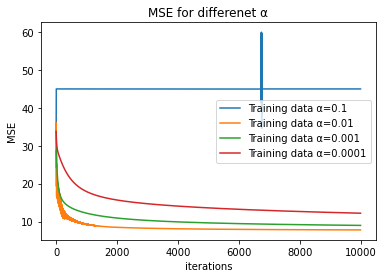

Run time: 140.1414119000001


In [30]:
from timeit import default_timer as timer

indexRemoveFeature = []             
alpha  = [0.1, 0.01, 0.001, 0.0001]
trainFirst = False
Niterations = 10000

start = timer()
main(alpha, Niterations, trainFirst, indexRemoveFeature)
end = timer()

print(f'Run time: {end - start}')

# Run with 30 first samples for training

Weighting matrix:

  0.42824382441689   1.679994421771367   -2.500460271426365   -1.1575373280780499   0.30351656439751357

  1.4720070902195037   -2.9179640705051026   -0.19449539050289427   -1.1662189597328496   1.5932163828194084

  -2.953812083555632   -2.492680874300987   4.3143856560290095   3.762072855731744   -1.8878297076795407
Error rate(train): 0.03333% 

Error rate(test):  0.02222% 



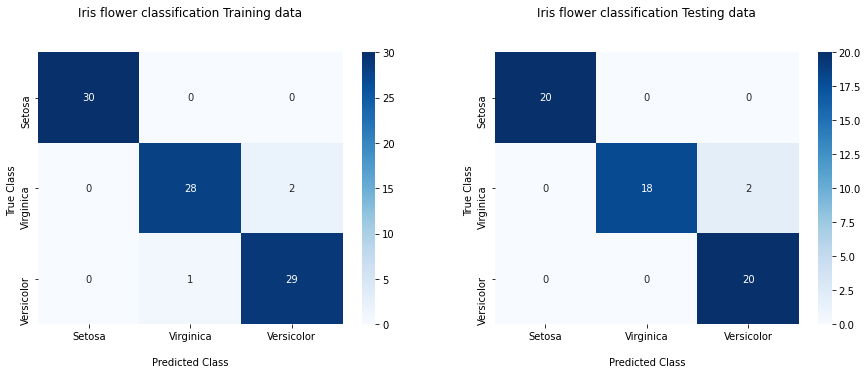

Run time: 7.6677951000001485


In [25]:
from timeit import default_timer as timer

indexRemoveFeature = []             
alpha  = [0.01]
trainFirst = True
Niterations = 2000

start = timer()
main(alpha, Niterations, trainFirst, indexRemoveFeature)
end = timer()

print(f'Run time: {end - start}')

# Run with 30 first samples for testing

Weighting matrix:

  0.4935730275402548   1.680883817126493   -2.641639512613744   -1.233810377176616   0.3099039898555521

  0.29288794750054603   -2.317397728364831   1.5780081701272508   -3.602611583357441   3.0041165394123266

  -2.1625344122227346   -2.921820738149311   3.559213732298057   4.26332276348111   -2.4527394619520164
Error rate(train): 0.05556% 

Error rate(test):  0.0% 



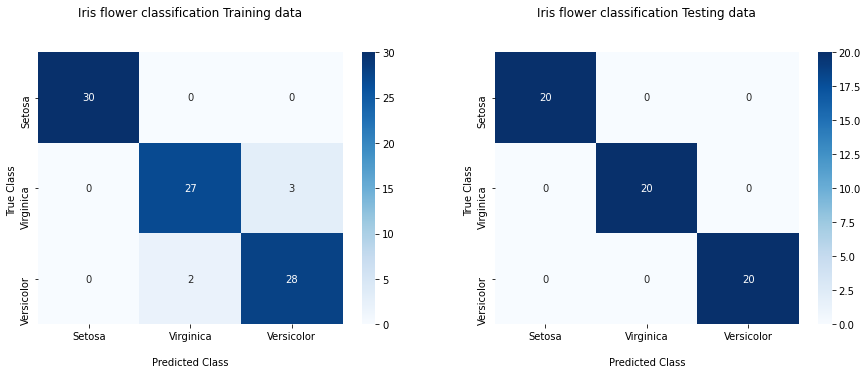

Run time: 7.701027900000554


In [26]:
from timeit import default_timer as timer

indexRemoveFeature = []             
alpha  = [0.01]
trainFirst = False
Niterations = 2000

start = timer()
main(alpha, Niterations, trainFirst, indexRemoveFeature)
end = timer()

print(f'Run time: {end - start}')

# Run with Sepal Width removed

Weighting matrix:

  1.6380229250036709   -3.0806672825572723   -1.4717965958594657   0.6442659178853978

  -0.6771087797025306   1.6168943644535712   -2.8240251516991464   0.25088723615129205

  -3.787146890956915   4.283660480887394   3.091668564233415   -2.4691458223813703
Error rate(train): 0.03333% 

Error rate(test):  0.03333% 



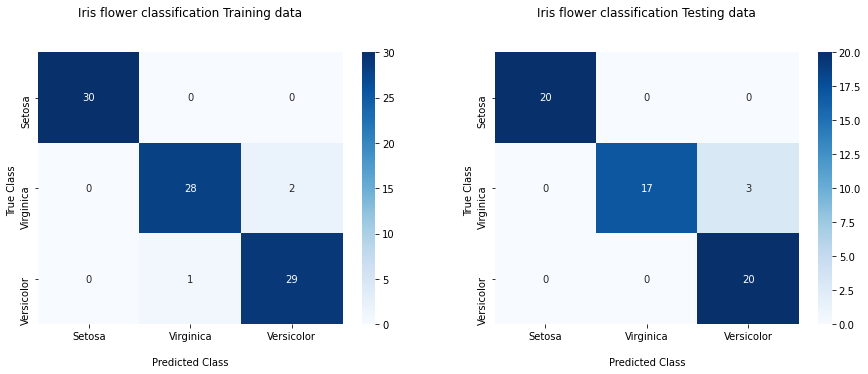

Run time: 7.593856500000584


In [27]:
from timeit import default_timer as timer

indexRemoveFeature = [1]             
alpha  = [0.01]
trainFirst = True
Niterations = 2000

start = timer()
main(alpha, Niterations, trainFirst, indexRemoveFeature)
end = timer()

print(f'Run time: {end - start}')

# Run with [Sepal Length, Sepal Width] removed

Weighting matrix:

  -1.5161177999568838   -2.3336683079110143   5.607135046407271

  1.0866509966542237   -2.1642650092382247   -2.1679978023777378

  0.3150858627085636   4.023209329357785   -8.19799459803529
Error rate(train): 0.06667% 

Error rate(test):  0.03333% 



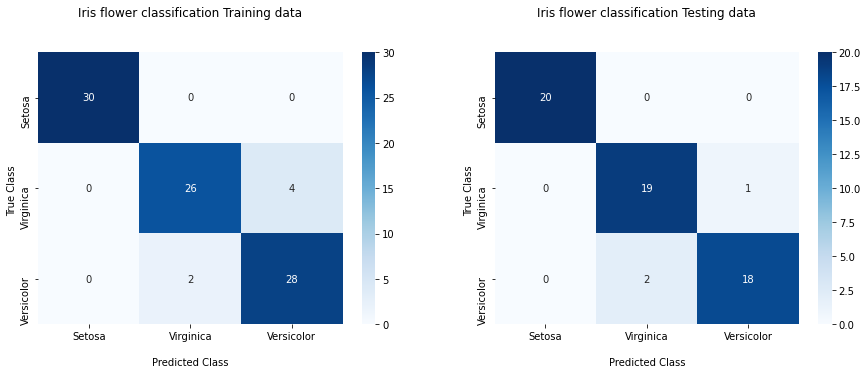

Run time: 7.210629100000006


In [28]:
from timeit import default_timer as timer

indexRemoveFeature = [0,1]             
alpha  = [0.01]
trainFirst = True
Niterations = 2000

start = timer()
main(alpha, Niterations, trainFirst, indexRemoveFeature)
end = timer()

print(f'Run time: {end - start}')

# Run with [Sepal Length, Sepal Width, Petal Length] removed

Weighting matrix:

  -5.747132589697124   4.124814074189152

  0.2829108404002836   -1.0244838623667747

  4.676246504146013   -7.724633858231827
Error rate(train): 0.04444% 

Error rate(test):  0.04444% 



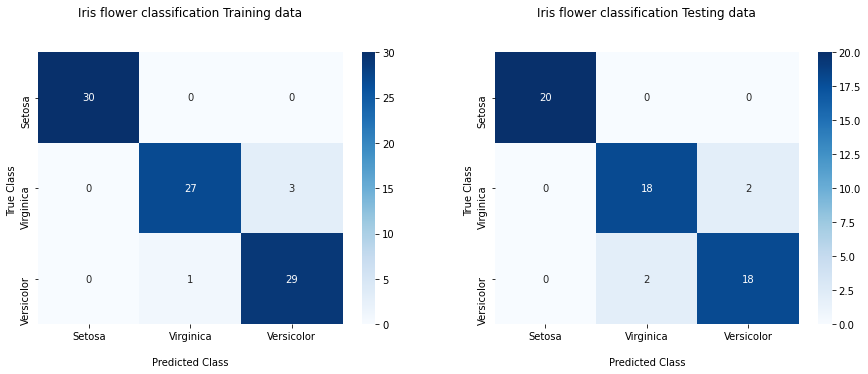

Run time: 7.38482329999988


In [29]:
from timeit import default_timer as timer

indexRemoveFeature = [0,1,2]             
alpha  = [0.01]
trainFirst = True
Niterations = 2000

start = timer()
main(alpha, Niterations, trainFirst, indexRemoveFeature)
end = timer()

print(f'Run time: {end - start}')